# SEPARATE AGN POPULATIONS INTO OBSC/UNOBSC 
We have several options. For the moment, use the lognormal mixture with a threshold to select 
sources with uncertain classification

This will produce a catalog with a few extra columns:
* gmw3 :: g-W3 color in the same photo system
* agn_class :: 0 (ubscured), 1 (obscured), 2 (uncertain)
* p_unobsc :: probability of class 0
* o_obsc :: probability of class 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from astropy.table import Table

In [2]:
#file = '/home/edonoso/incubator/wiseagn/C75_hscmatched2arcs_wisematched2arcs.fits'
file = '/home/edonoso/incubator/wiseagn/C75_hpwm_2arc_wise_1arc.fits'
df   = Table.read(file).to_pandas()
colz = 'photoz_best_pz'  #column for redshift

In [3]:
# Make g-W3 color
df['gmw3'] = df['g_cmodel_mag'] - (df['W3mag']+5.174)
df = df.dropna(subset=[colz,'gmw3']).reset_index(drop=True)

In [4]:
# Sort by redshift (optional but useful for plotting later)
df = df.sort_values(colz).reset_index(drop=True)

## LogNormal Mixture with threshold - version 2

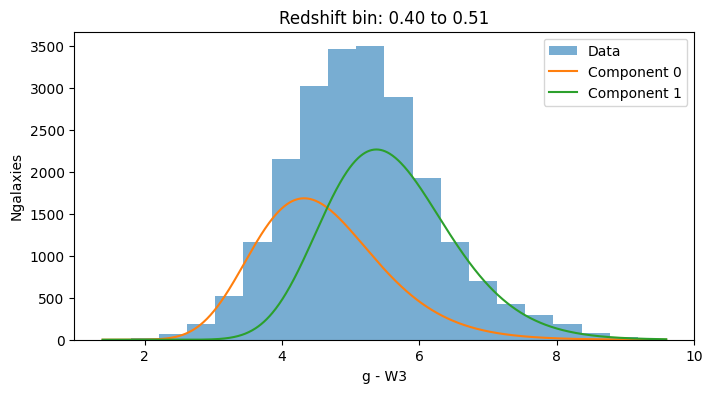

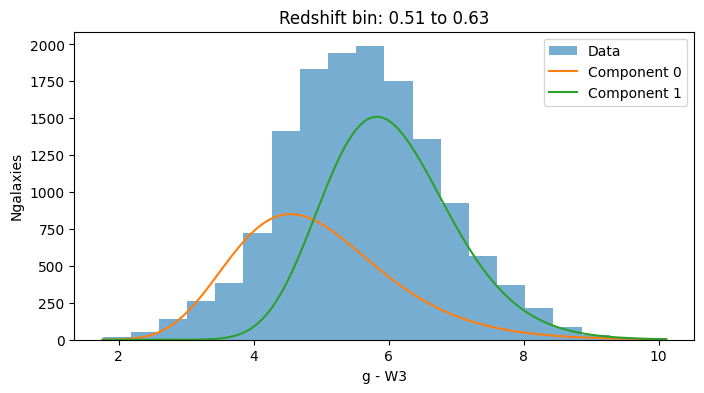

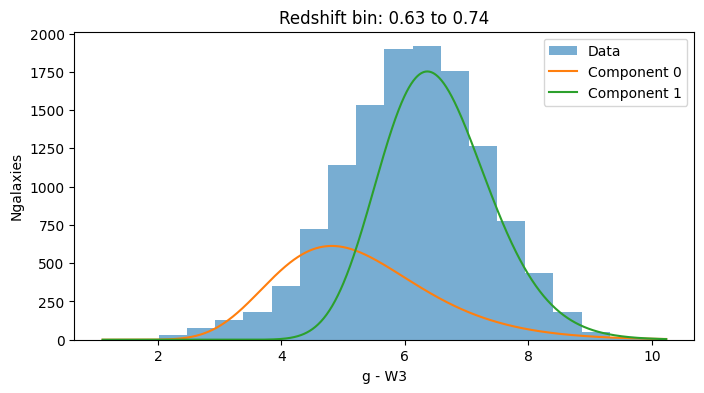

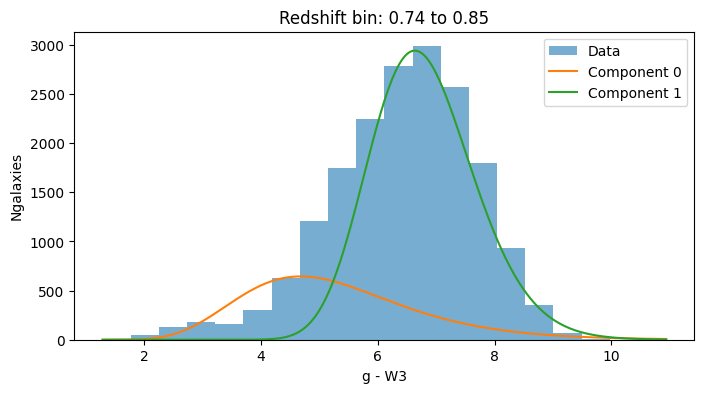

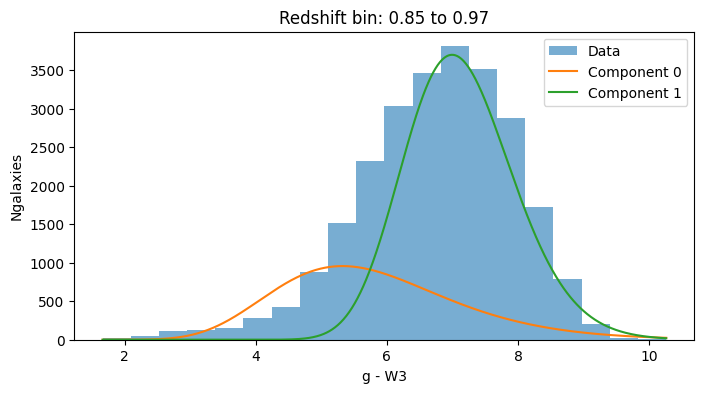

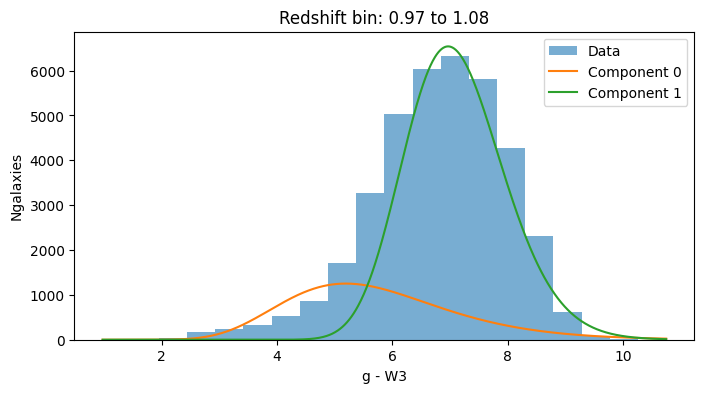

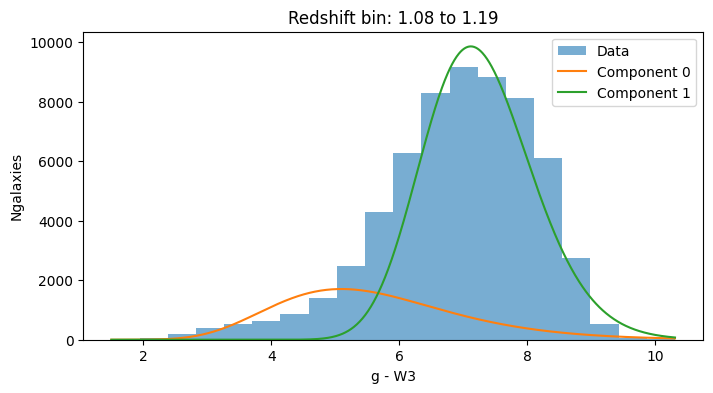

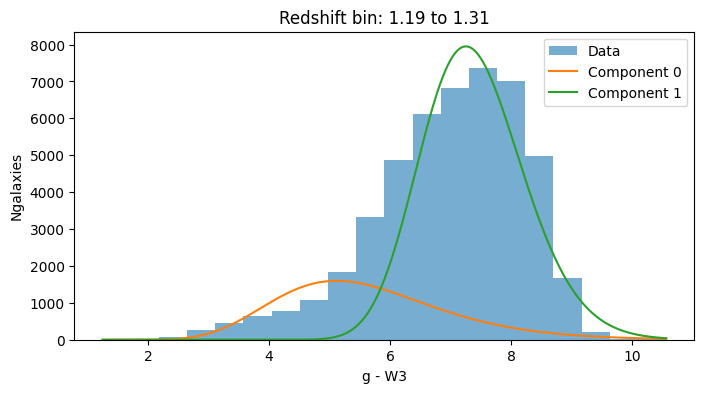

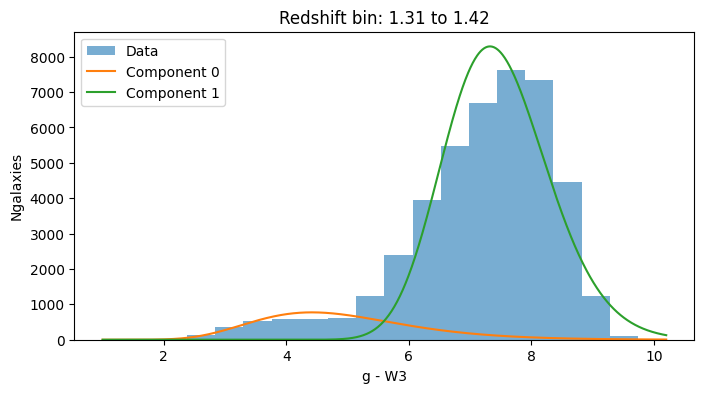

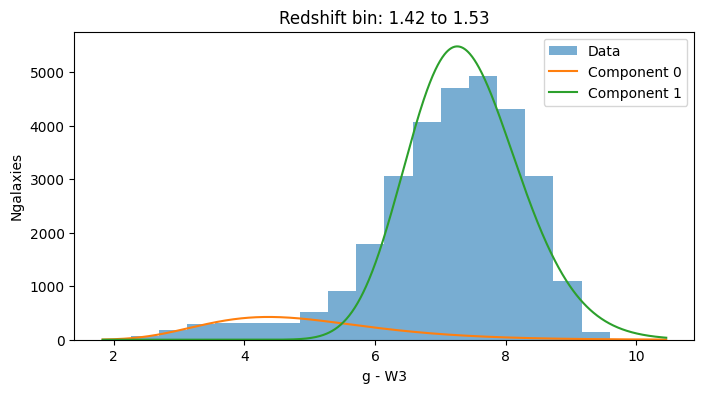

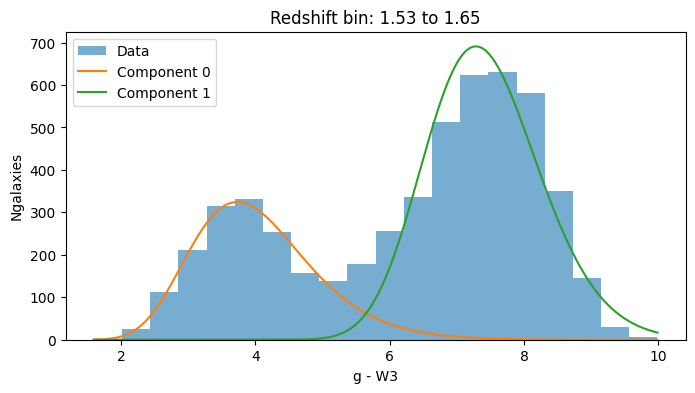

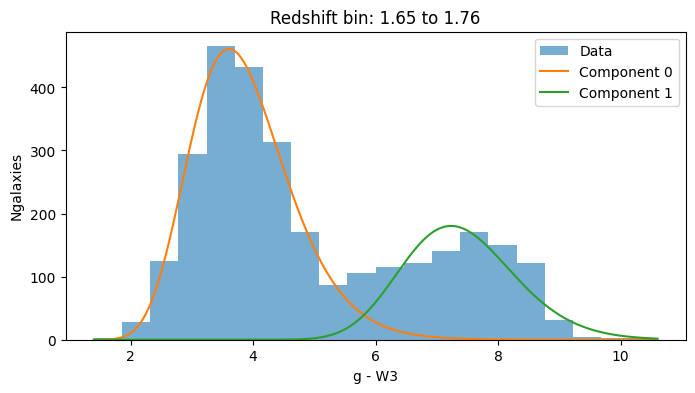

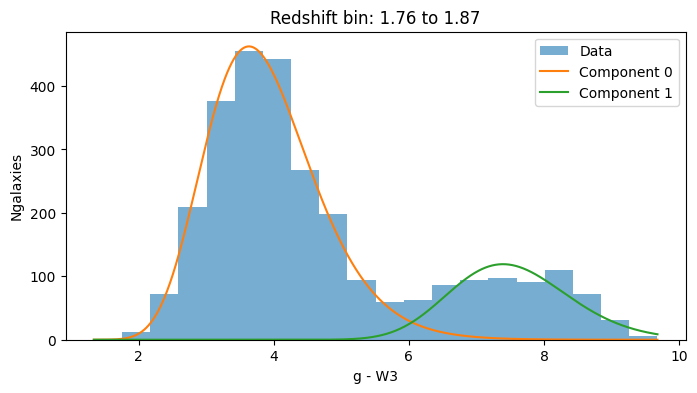

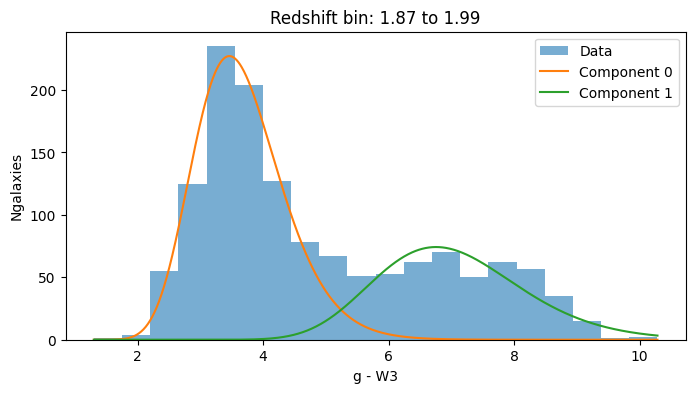

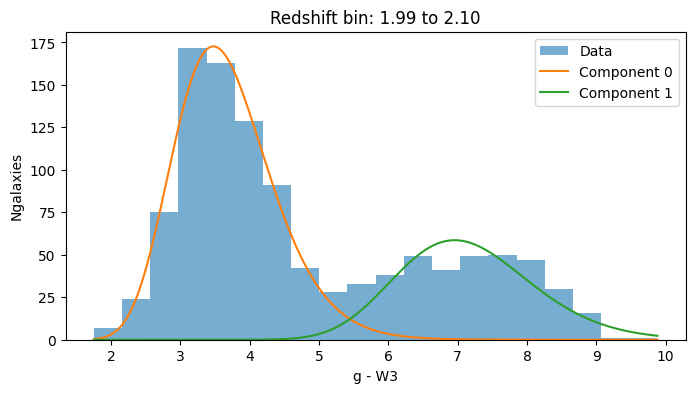

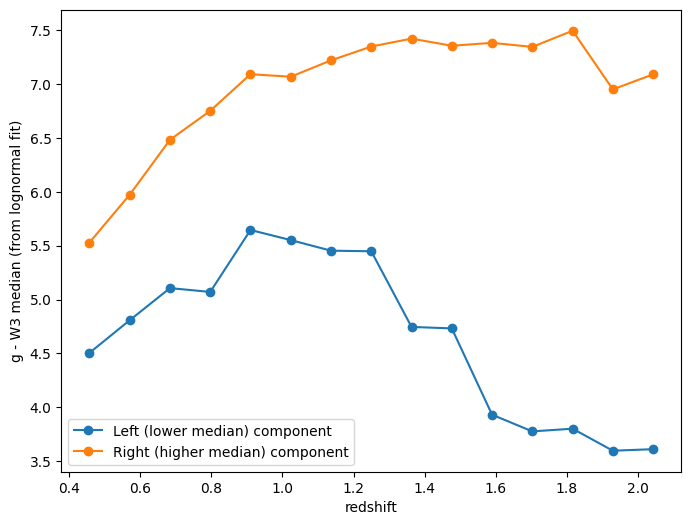

In [5]:
# Define redshift bins for fitting and probability uncertainty threshold
n_bins = 15        # nr of bins
z1     = 0.4       # low-z limit for fit
z2     = 2.1       # high-z limit for fit
uthreshold = 0.4   # uncertainty threshold for classification

# Build redshift bins
redshift_bins = np.linspace(z1, z2, n_bins + 1)

bin_centers = []
component_medians = []

df['p_unobsc'] = np.nan  # probability for component 0 (lower median) - unobscured
df['p_obsc'] = np.nan  # probability for component 1 (higher median) - obscured

for i in range(n_bins):
    # Select data in redshift bin
    mask = (df[colz] >= redshift_bins[i]) & (df[colz] < redshift_bins[i+1])
    sub_df = df[mask]
    
    if len(sub_df) < 20:  # skip bins with too few galaxies
        continue
    
    # Reshape data and transform to log space
    x_data = sub_df['gmw3'].values.reshape(-1, 1)
    log_x = np.log(x_data)
    
    # Fit a 2-component Gaussian mixture in log space
    gmm = GaussianMixture(n_components=2, random_state=0)
    gmm.fit(log_x)
    
     # Get the posterior probabilities and predict initial labels from the GMM
    probs = gmm.predict_proba(log_x)
    original_labels = gmm.predict(log_x)
    
    # Reassign labels so that the component with the lower mean (in log space) is always label 0 (unobsc)
    order = np.argsort(gmm.means_.flatten()) 
    mapping = {order[0]: 0, order[1]: 1}
    fixed_labels = np.array([mapping[label] for label in original_labels])

    # Resort probs and add columns for probabilities
    sorted_probs = probs[:, order]
    df.loc[sub_df.index, 'p_unobsc'] = sorted_probs[:, 0]
    df.loc[sub_df.index, 'p_obsc'] = sorted_probs[:, 1]
    
    # Uncertain objects: if the absolute difference between the two probabilities is less than the threshold, 
    # label as uncertain (class 2)
    prob_diff = np.abs(sorted_probs[:, 0] - sorted_probs[:, 1])
    fixed_labels[prob_diff < uthreshold] = 2
    
    # Save the fixed labels into the df
    df.loc[sub_df.index, 'agn_class'] = fixed_labels

    # All this is just for plotting...
    bin_center = (redshift_bins[i] + redshift_bins[i+1]) / 2.
    bin_centers.append(bin_center)
    # For a lognormal distribution, the median is exp(mu) where mu is the log-mean. Sort the means so that
    # the lower median comes first
    medians = np.exp(np.sort(gmm.means_.flatten()))
    component_medians.append(medians)
    
    # Plot histogram and fitted lognormal PDFs:
    plt.figure(figsize=(8, 4))
    plt.hist(x_data, bins=20, alpha=0.6, label='Data')
    x_range = np.linspace(x_data.min(), x_data.max(), 1000)
    
    for j in range(2):  # for each component (for simplicity label comp 0 and comp 1)
        # Identify the component index corresponding to the sorted log-mean:
        sorted_means = np.sort(gmm.means_.flatten())
        comp_index = np.where(gmm.means_.flatten() == sorted_means[j])[0][0]
        mu = gmm.means_[comp_index][0]
        sigma = np.sqrt(gmm.covariances_[comp_index][0][0])
        weight = gmm.weights_[comp_index]
        # Lognormal PDF:
        # f(x) = weight * (1/(x * sigma * sqrt(2*pi))) * exp(-((ln(x) - mu)^2 / (2*sigma^2)))
        pdf = weight * (1 / (x_range * sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((np.log(x_range) - mu)/sigma)**2)
        bin_width = (x_data.max() - x_data.min()) / 20
        plt.plot(x_range, pdf * len(x_data) * bin_width, label=f'Component {j}')
        
    plt.title(f"Redshift bin: {redshift_bins[i]:.2f} to {redshift_bins[i+1]:.2f}")
    plt.xlabel("g - W3")
    plt.ylabel("Ngalaxies")
    plt.legend()
    plt.show()

#####################################################################################
# Is this ok? A few dozen UNC sources get assigned low probabilities in both models, but they are very red to not be obscured --> force them?
df.loc[(df['gmw3'] > 8) & (df[colz]>=z1) & (df[colz]<=z2), 'agn_class'] = 1
####################################################################################

# Just for sanity, plot the evolution of the fitted medians with redshift
component_medians = np.array(component_medians)  #(n_valid_bins, 2)
plt.figure(figsize=(8, 6))
plt.plot(bin_centers, component_medians[:, 0], 'o-', label="Left (lower median) component")
plt.plot(bin_centers, component_medians[:, 1], 'o-', label="Right (higher median) component")
plt.xlabel("redshift")
plt.ylabel("g - W3 median (from lognormal fit)")
plt.legend()
plt.show()

In [6]:
# Save dataframe to disk
df.to_parquet('C75_hpwm_gmmclass.parquet')

## NO--- Gaussian Mixture

BIN:  0  ===================


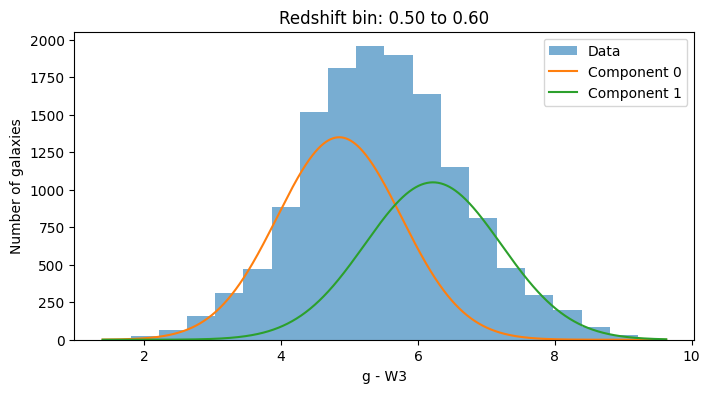

BIN:  1  ===================


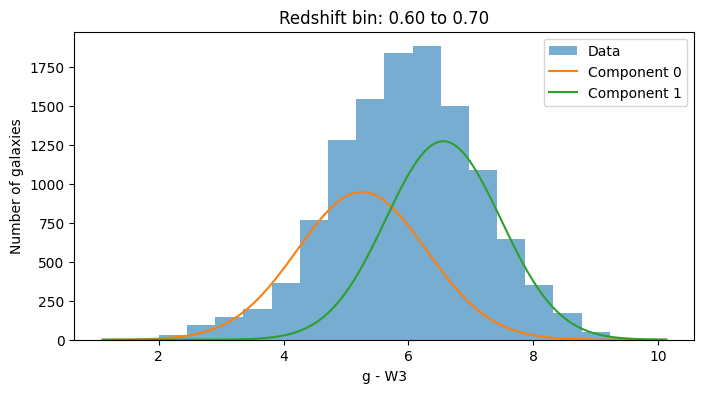

BIN:  2  ===================


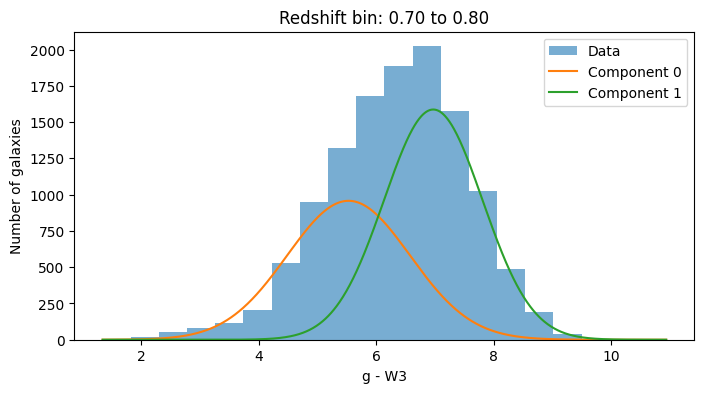

BIN:  3  ===================


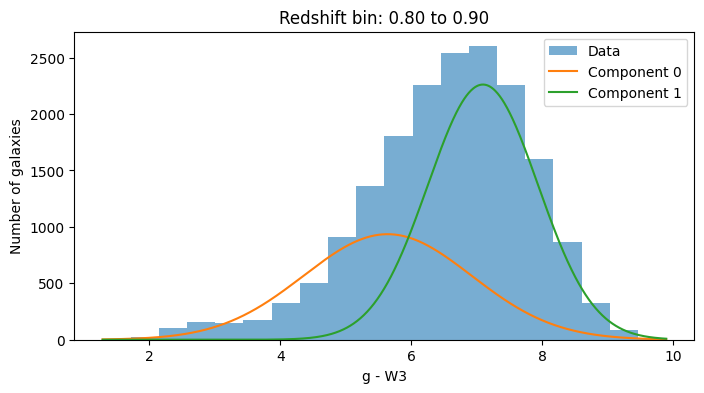

BIN:  4  ===================


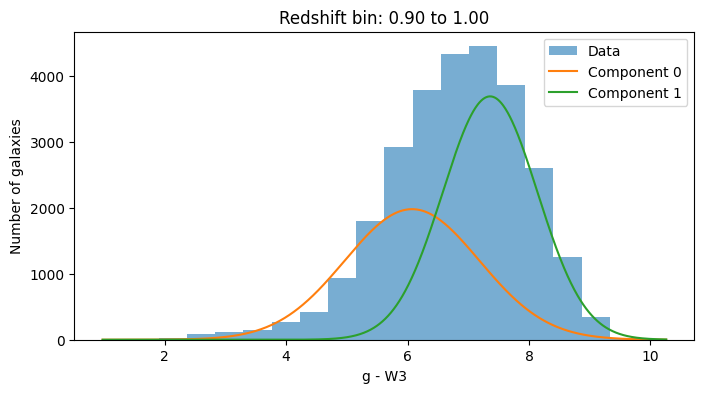

BIN:  5  ===================


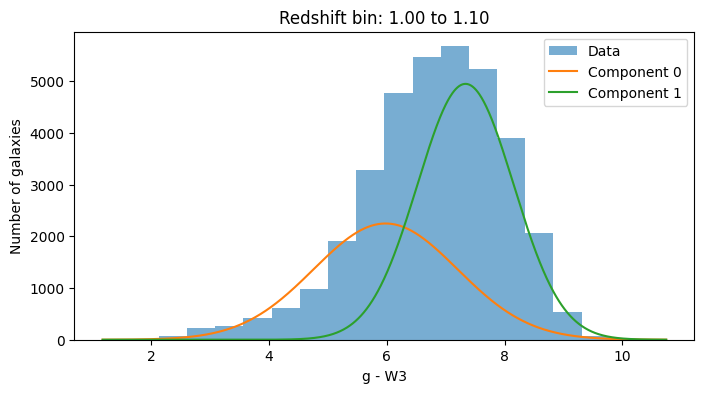

BIN:  6  ===================


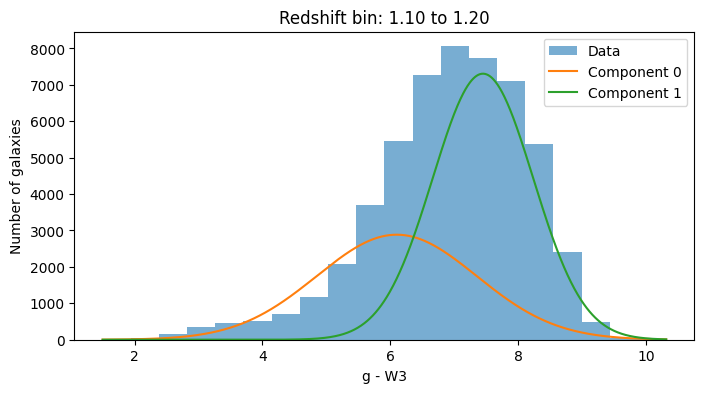

BIN:  7  ===================


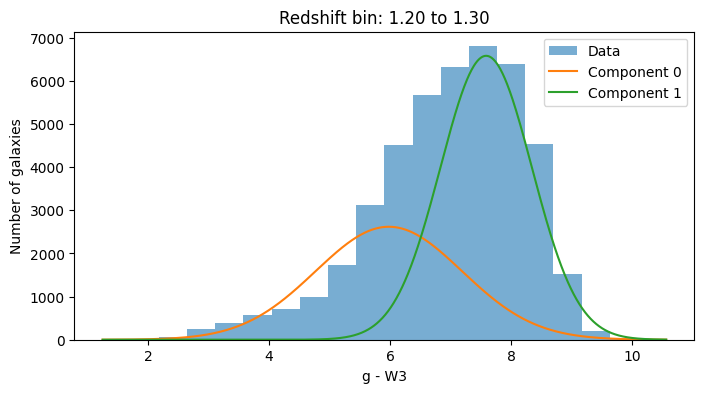

BIN:  8  ===================


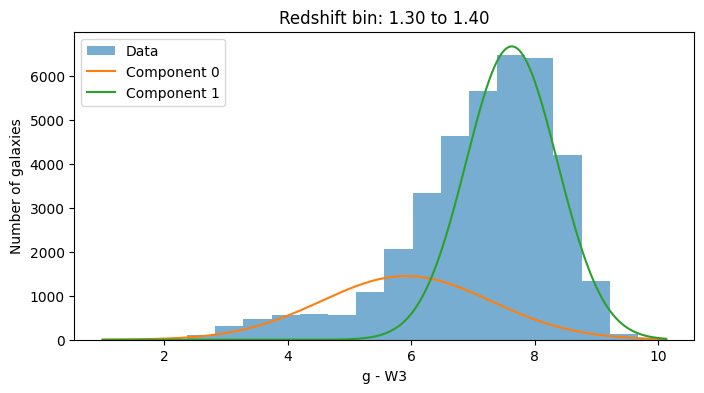

BIN:  9  ===================


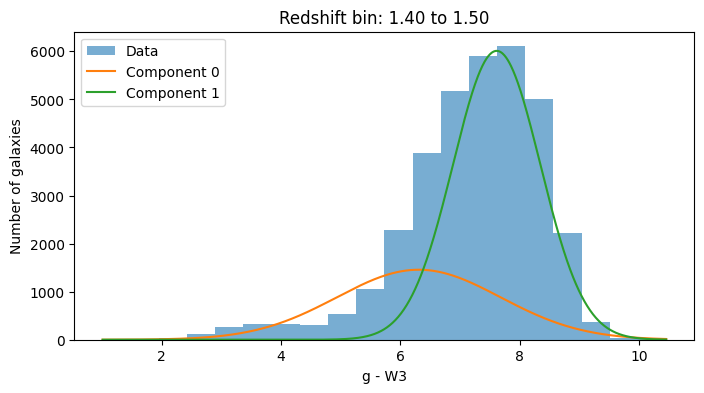

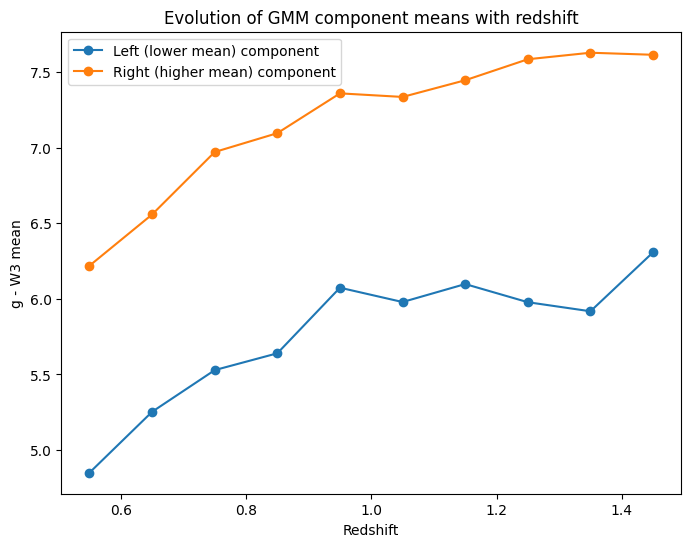

In [136]:
# Define redshift bins
n_bins = 10
#redshift_bins = np.linspace(df[colz].min(), df[colz].max(), n_bins + 1)
redshift_bins = np.linspace(0.5, 1.5, n_bins + 1)

# Store results
classifications = []
bin_centers = []
component_means = []

for i in range(n_bins):
    print('BIN: ',i,' ===================')
    # Create mask for the current redshift bin
    mask = (df[colz] >= redshift_bins[i]) & (df[colz] < redshift_bins[i+1])
    sub_df = df[mask]
    
    if len(sub_df) < 20:  # skip bins with too few galaxies
        continue
    
    # Reshape data for the GaussianMixture (expects 2D array)
    colors = sub_df['gmw3'].values.reshape(-1, 1)
    
    # Fit a 2-component GMM
    gmm = GaussianMixture(n_components=2, random_state=0)
    gmm.fit(colors)
    
    # Predict the labels for each data point
    labels = gmm.predict(colors)
    
    # --- Reassign labels so that the lower mean (leftmost Gaussian) is always 0 ---
    # Get the ordering of components by their means
    order = np.argsort(gmm.means_.flatten())  # order[0] is the component with the lower mean
    # Create a mapping from original label to new label:
    mapping = {order[0]: 0, order[1]: 1}
    # Apply the mapping to each label:
    fixed_labels = np.array([mapping[label] for label in labels])
    # ---------------------------------------------------------------------------
    
    # Save the consistent classifications back into the DataFrame
    df.loc[sub_df.index, 'agn_class'] = fixed_labels
    
    # Record bin center and the re-ordered component means for further analysis
    bin_center = (redshift_bins[i] + redshift_bins[i+1]) / 2.
    bin_centers.append(bin_center)
    # Reorder the means according to our mapping: left (0) then right (1)
    means_ordered = np.sort(gmm.means_.flatten())
    component_means.append(means_ordered)
    
    # Optionally, plot the distribution for the current bin
    plt.figure(figsize=(8, 4))
    plt.hist(colors, bins=20, alpha=0.6, label='Data')
    x = np.linspace(colors.min(), colors.max(), 1000).reshape(-1, 1)
    for j in range(2):
        # Use the sorted means: means_ordered[0] for left Gaussian, means_ordered[1] for right Gaussian
        mean = means_ordered[j]
        # Identify the corresponding covariance: we need to find which component in the original gmm corresponds to the j-th sorted mean.
        comp_index = np.where(gmm.means_.flatten() == mean)[0][0]
        std = np.sqrt(gmm.covariances_[comp_index][0][0])
        weight = gmm.weights_[comp_index]
        y = weight * 1/(np.sqrt(2*np.pi)*std) * np.exp(-0.5*((x-mean)/std)**2)
        plt.plot(x, y * len(colors) * (colors.max() - colors.min())/20., label=f'Component {j}')
    plt.title(f"Redshift bin: {redshift_bins[i]:.2f} to {redshift_bins[i+1]:.2f}")
    plt.xlabel("g - W3")
    plt.ylabel("Number of galaxies")
    plt.legend()
    plt.show()

# Plot the evolution of the component means with redshift
component_means = np.array(component_means)  # shape: (n_valid_bins, 2)
plt.figure(figsize=(8, 6))
plt.plot(bin_centers, component_means[:, 0], 'o-', label="Left (lower mean) component")
plt.plot(bin_centers, component_means[:, 1], 'o-', label="Right (higher mean) component")
plt.xlabel("Redshift")
plt.ylabel("g - W3 mean")
plt.title("Evolution of GMM component means with redshift")
plt.legend()
plt.show()


In [137]:
mkuno = df['agn_class']==1
mkobs = df['agn_class']==0

(0.3, 1.7)

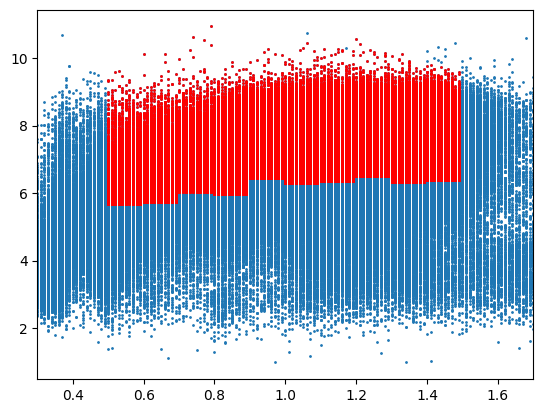

In [138]:
plt.scatter(df[colz],df['gmw3'],s=1)
plt.scatter(df[colz][mkuno],df['gmw3'][mkuno],s=1,color='r')
plt.xlim([0.3,1.7])

In [140]:
df.to_parquet('C75_gmmclass.parquet')

## NO--- LogNormal Mixture

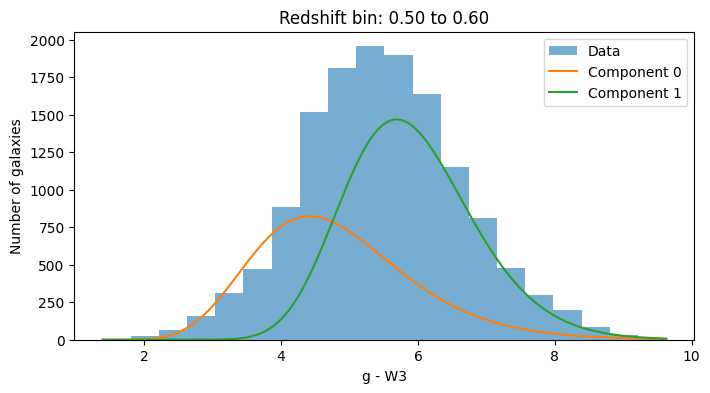

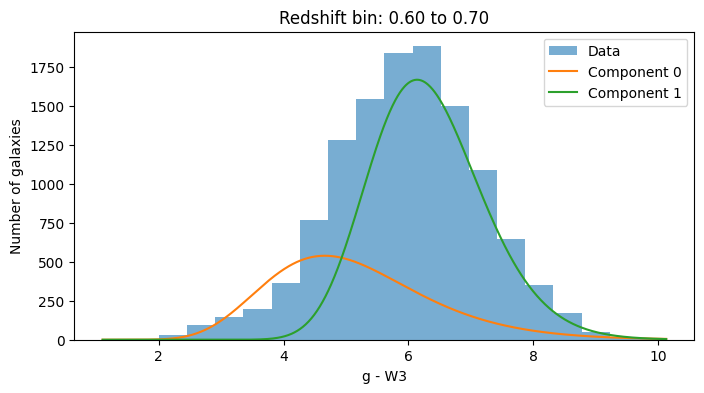

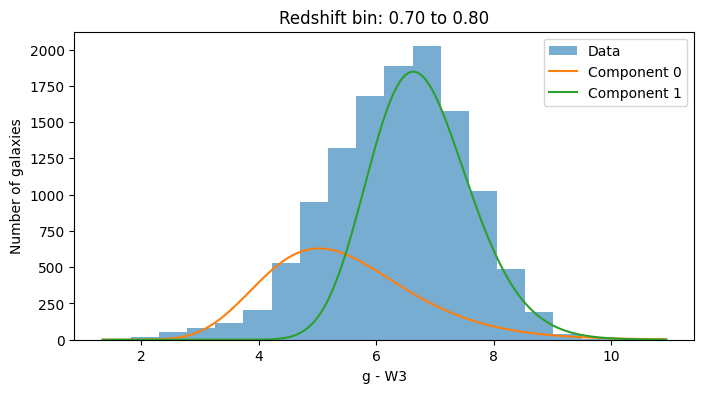

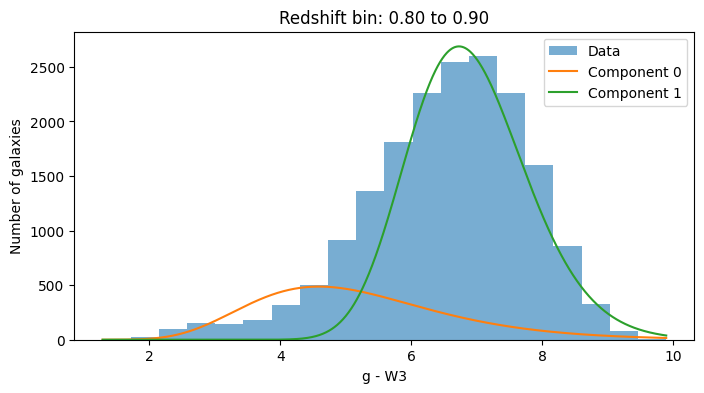

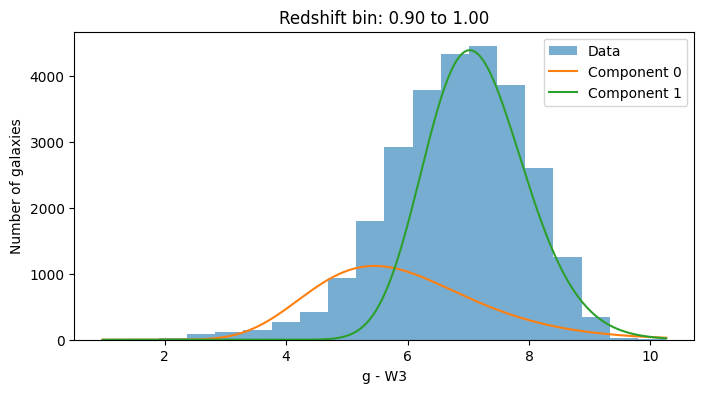

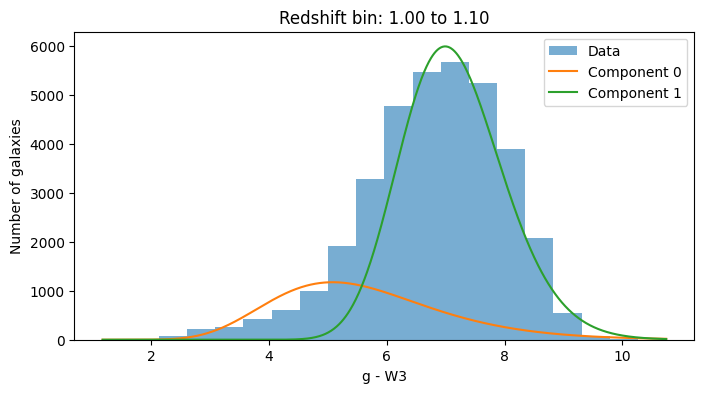

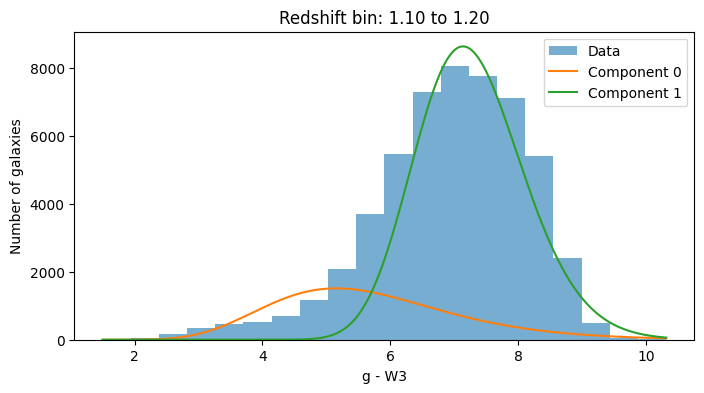

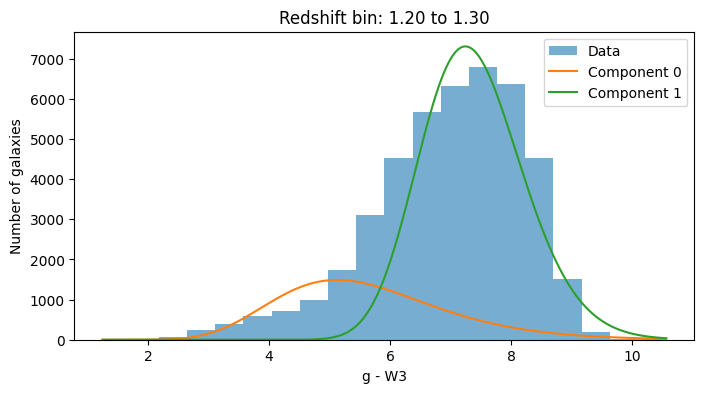

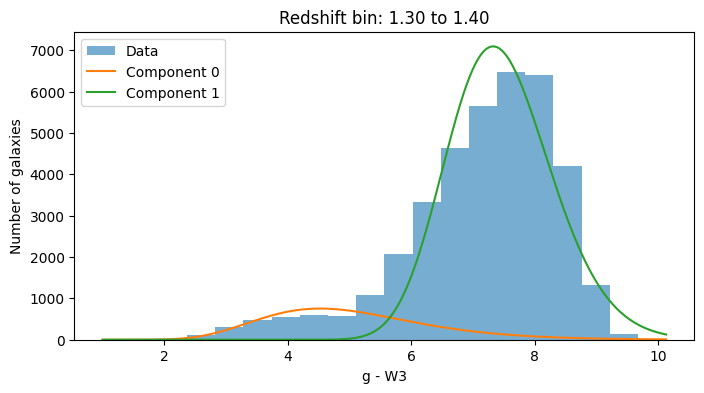

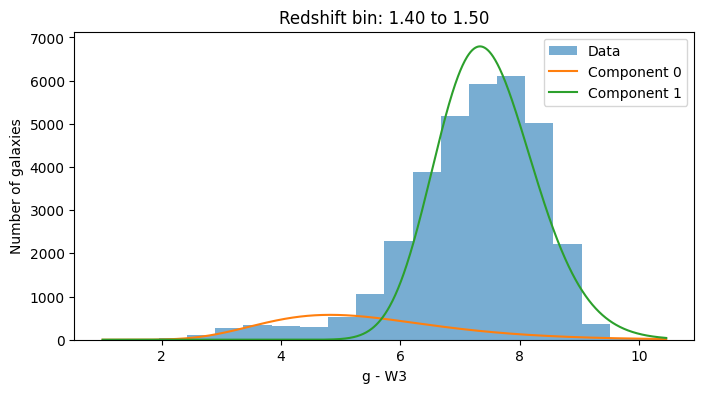

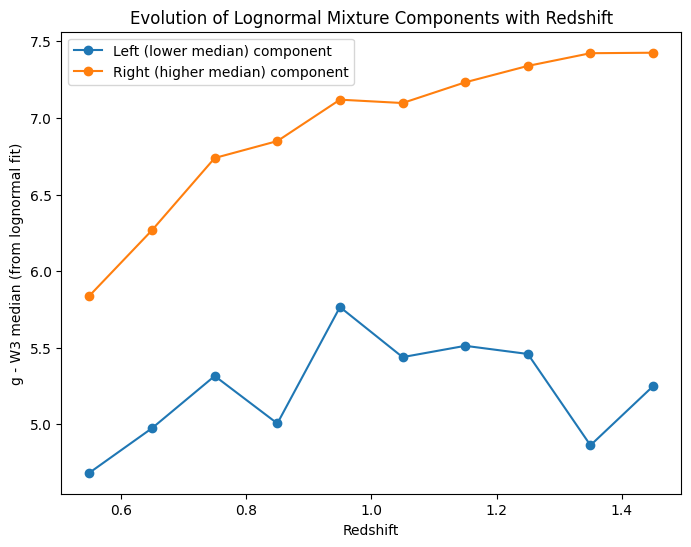

In [150]:
# Define redshift bins
n_bins = 10
#redshift_bins = np.linspace(df[colz].min(), df[colz].max(), n_bins + 1)
redshift_bins = np.linspace(0.5, 1.5, n_bins + 1)

bin_centers = []
component_medians = []  # we record medians from the lognormal fits

for i in range(n_bins):
    # Select data in the current redshift bin
    mask = (df[colz] >= redshift_bins[i]) & (df[colz] < redshift_bins[i+1])
    sub_df = df[mask]
    
    if len(sub_df) < 20:  # skip bins with too few galaxies
        continue
    
    # Reshape data for fitting and transform to log space.
    x_data = sub_df['gmw3'].values.reshape(-1, 1)
    log_x = np.log(x_data)
    
    # Fit a 2-component Gaussian mixture in log space.
    gmm = GaussianMixture(n_components=2, random_state=0)
    gmm.fit(log_x)
    
    # Predict labels in log space.
    labels = gmm.predict(log_x)
    
    # Reassign labels so that the component with the lower log-mean (i.e. lower median in original space) is label 0.
    order = np.argsort(gmm.means_.flatten())  # order[0] has the lower log-mean
    mapping = {order[0]: 0, order[1]: 1}
    fixed_labels = np.array([mapping[label] for label in labels])
    df.loc[sub_df.index, 'agn_class'] = fixed_labels
    
    # Record bin center and the medians of the fitted lognormals.
    bin_center = (redshift_bins[i] + redshift_bins[i+1]) / 2.
    bin_centers.append(bin_center)
    # For a lognormal distribution, the median is exp(mu) where mu is the mean in log space.
    means_sorted = np.sort(gmm.means_.flatten())
    component_medians.append(np.exp(means_sorted))
    
    # Plot the histogram of the original g_W3 values and overlay the fitted lognormal components.
    plt.figure(figsize=(8, 4))
    plt.hist(x_data, bins=20, alpha=0.6, label='Data')
    x_range = np.linspace(x_data.min(), x_data.max(), 1000)
    
    for j in range(2):
        # Find the corresponding component (based on the sorted order).
        comp_index = np.where(gmm.means_.flatten() == means_sorted[j])[0][0]
        mu = gmm.means_[comp_index][0]
        sigma = np.sqrt(gmm.covariances_[comp_index][0][0])
        weight = gmm.weights_[comp_index]
        # Lognormal PDF: f(x) = (1/(x * sigma * sqrt(2*pi))) * exp(- (ln(x)-mu)^2/(2*sigma^2) )
        pdf = weight * (1 / (x_range * sigma * np.sqrt(2 * np.pi))) * \
              np.exp(-0.5 * ((np.log(x_range) - mu) / sigma)**2)
        # Scale the PDF to match the histogram counts.
        bin_width = (x_data.max() - x_data.min()) / 20
        plt.plot(x_range, pdf * len(x_data) * bin_width, label=f'Component {j}')
    
    plt.title(f"Redshift bin: {redshift_bins[i]:.2f} to {redshift_bins[i+1]:.2f}")
    plt.xlabel("g - W3")
    plt.ylabel("Number of galaxies")
    plt.legend()
    plt.show()

# Plot the evolution of the fitted medians (from the lognormal fits) as a function of redshift.
component_medians = np.array(component_medians)  # shape: (n_valid_bins, 2)
plt.figure(figsize=(8, 6))
plt.plot(bin_centers, component_medians[:, 0], 'o-', label="Left (lower median) component")
plt.plot(bin_centers, component_medians[:, 1], 'o-', label="Right (higher median) component")
plt.xlabel("Redshift")
plt.ylabel("g - W3 median (from lognormal fit)")
plt.title("Evolution of Lognormal Mixture Components with Redshift")
plt.legend()
plt.show()


In [151]:
df.to_parquet('C75_lognmmclass.parquet')

## NO--- LogNormal Mixture with threshold

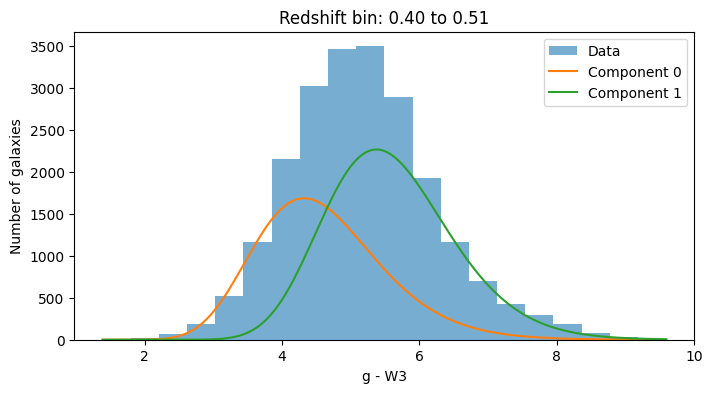

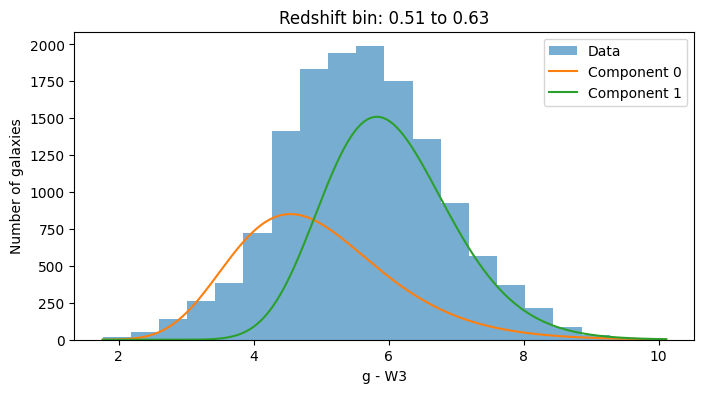

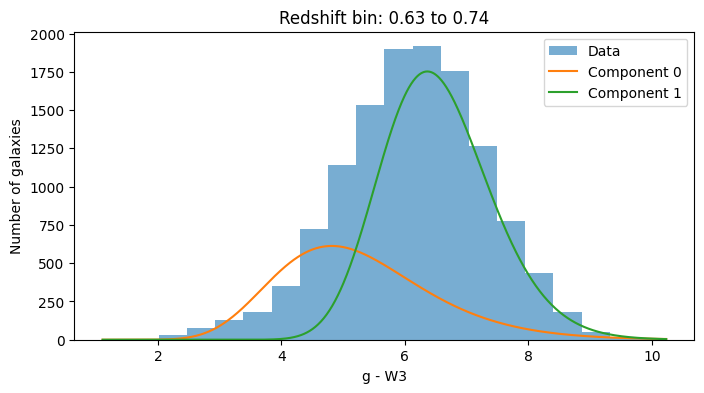

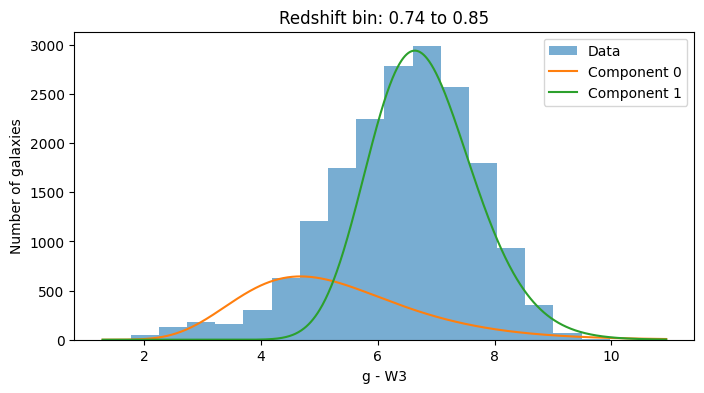

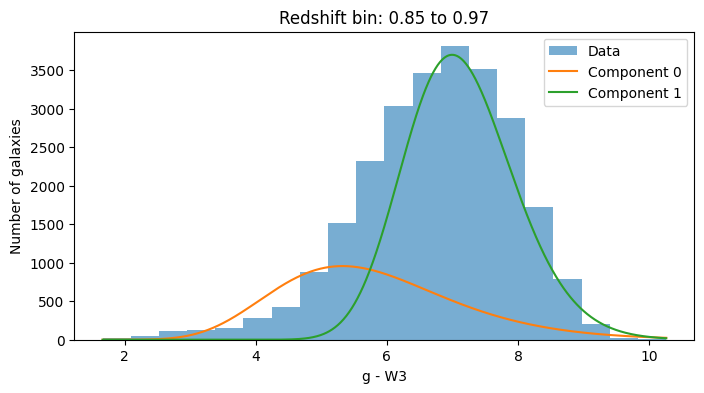

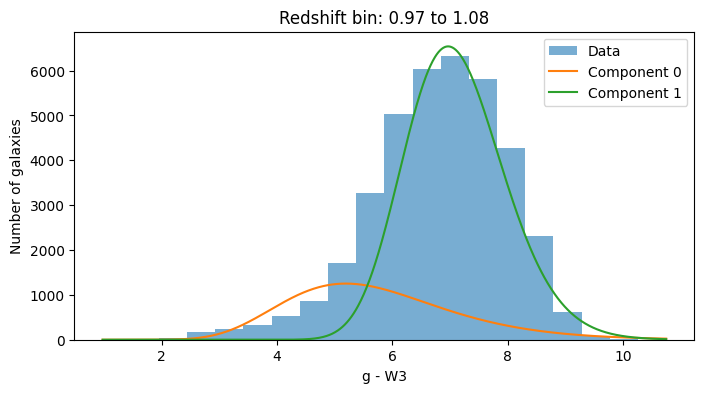

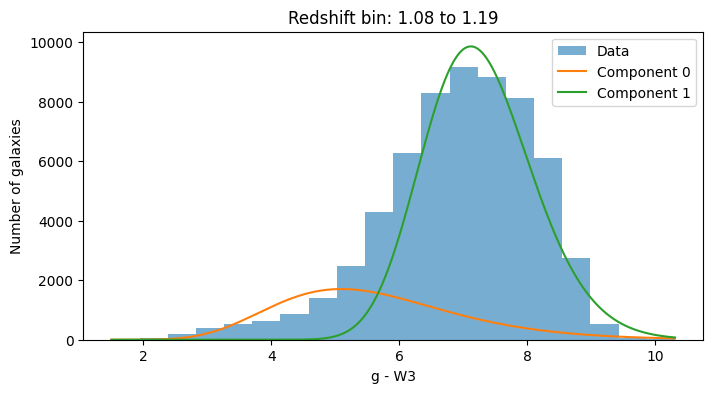

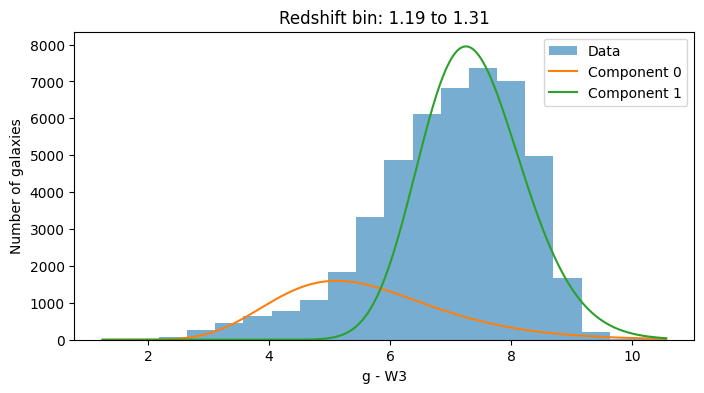

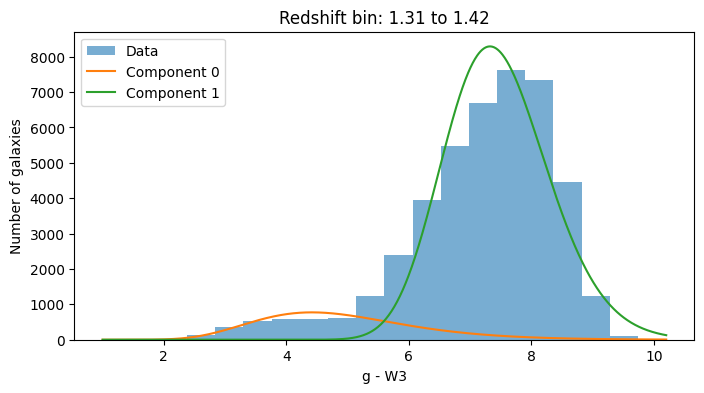

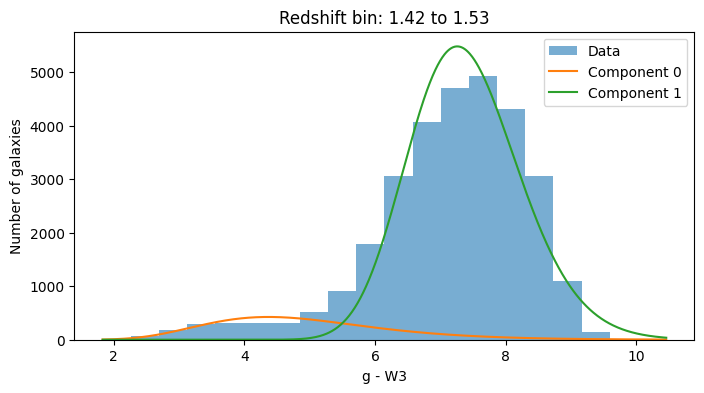

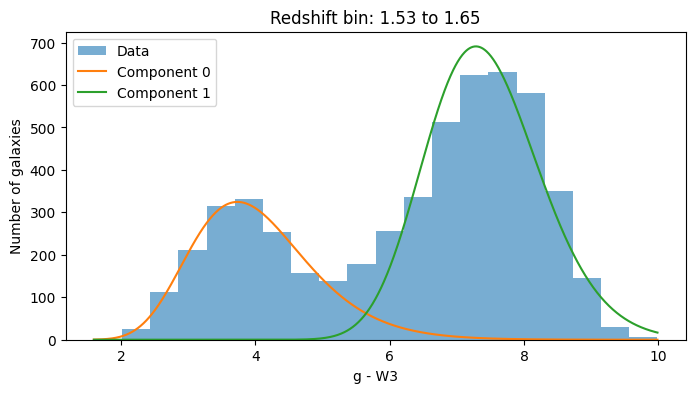

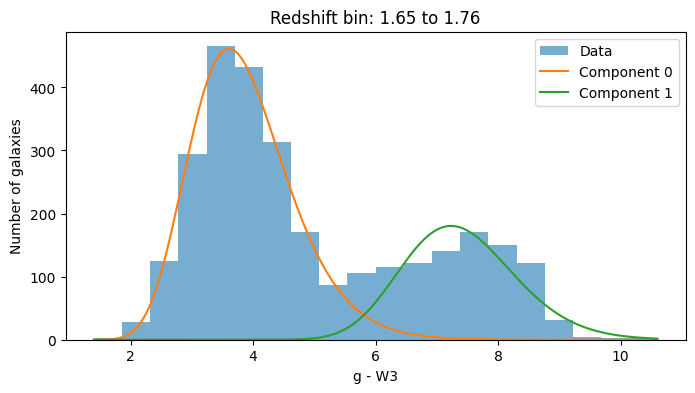

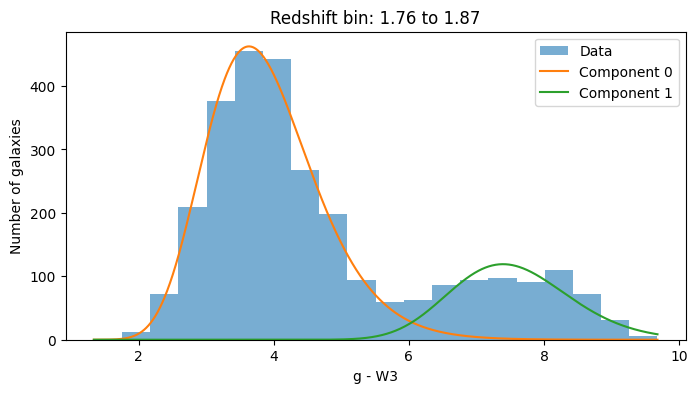

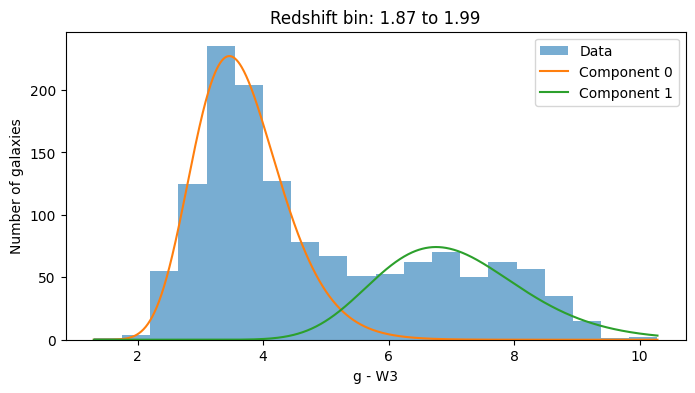

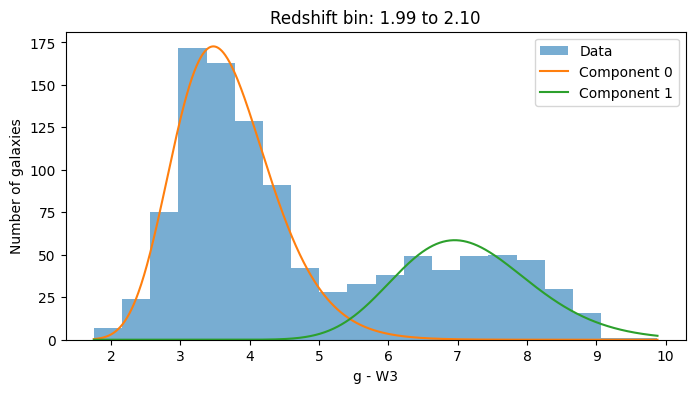

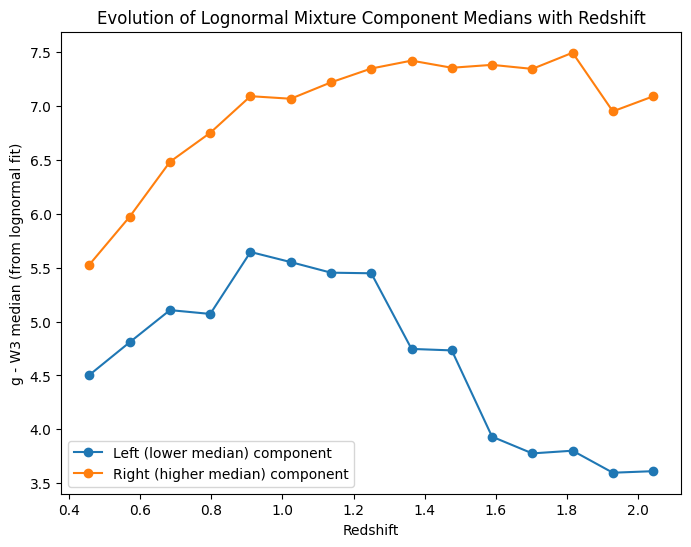

In [36]:
# Define redshift bins
n_bins = 15
#redshift_bins = np.linspace(df[colz].min(), df[colz].max(), n_bins + 1)
redshift_bins = np.linspace(0.4, 2.1, n_bins + 1)

uncertainty_threshold = 0.4

bin_centers = []
component_medians = []  # we record medians from the lognormal fits

for i in range(n_bins):
    # Select data in the current redshift bin
    mask = (df[colz] >= redshift_bins[i]) & (df[colz] < redshift_bins[i+1])
    sub_df = df[mask]
    
    if len(sub_df) < 20:  # skip bins with too few galaxies
        continue
    
    # Reshape data for fitting and transform to log space.
    x_data = sub_df['gmw3'].values.reshape(-1, 1)
    log_x = np.log(x_data)
    
    # Fit a 2-component Gaussian mixture in log space.
    gmm = GaussianMixture(n_components=2, random_state=0)
    gmm.fit(log_x)
    
     # Get the posterior probabilities:
    probs = gmm.predict_proba(log_x)
    
    # Predict initial labels from the GMM:
    original_labels = gmm.predict(log_x)
    
    # Reassign labels so that the component with the lower mean (in log space) is always label 0:
    order = np.argsort(gmm.means_.flatten())  # order[0]: lower log-mean, order[1]: higher log-mean
    mapping = {order[0]: 0, order[1]: 1}
    fixed_labels = np.array([mapping[label] for label in original_labels])
    
    # Determine uncertain objects:
    # If the absolute difference between the two probabilities is less than our threshold, label as uncertain (2)
    prob_diff = np.abs(probs[:, 0] - probs[:, 1])
    fixed_labels[prob_diff < uncertainty_threshold] = 2
    
    # Save the fixed labels into the DataFrame:
    df.loc[sub_df.index, 'agn_class'] = fixed_labels
    
    # Record the center of the redshift bin:
    bin_center = (redshift_bins[i] + redshift_bins[i+1]) / 2.
    bin_centers.append(bin_center)
    # For a lognormal distribution, the median is exp(mu) where mu is the log-mean.
    # We sort the means so that the lower median comes first.
    medians = np.exp(np.sort(gmm.means_.flatten()))
    component_medians.append(medians)
    
    # Plot histogram and overlaid fitted lognormal PDFs:
    plt.figure(figsize=(8, 4))
    plt.hist(x_data, bins=20, alpha=0.6, label='Data')
    x_range = np.linspace(x_data.min(), x_data.max(), 1000)
    
    # Overlay each lognormal component:
    for j in range(2):
        # Identify the component index corresponding to the sorted log-mean:
        sorted_means = np.sort(gmm.means_.flatten())
        comp_index = np.where(gmm.means_.flatten() == sorted_means[j])[0][0]
        mu = gmm.means_[comp_index][0]
        sigma = np.sqrt(gmm.covariances_[comp_index][0][0])
        weight = gmm.weights_[comp_index]
        # Lognormal PDF:
        # f(x) = weight * (1/(x * sigma * sqrt(2*pi))) * exp(-((ln(x) - mu)^2 / (2*sigma^2)))
        pdf = weight * (1 / (x_range * sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((np.log(x_range) - mu)/sigma)**2)
        bin_width = (x_data.max() - x_data.min()) / 20
        plt.plot(x_range, pdf * len(x_data) * bin_width, label=f'Component {j}')
        
    plt.title(f"Redshift bin: {redshift_bins[i]:.2f} to {redshift_bins[i+1]:.2f}")
    plt.xlabel("g - W3")
    plt.ylabel("Number of galaxies")
    plt.legend()
    plt.show()

# Plot the evolution of the fitted medians with redshift:
component_medians = np.array(component_medians)  # shape: (n_valid_bins, 2)
plt.figure(figsize=(8, 6))
plt.plot(bin_centers, component_medians[:, 0], 'o-', label="Left (lower median) component")
plt.plot(bin_centers, component_medians[:, 1], 'o-', label="Right (higher median) component")
plt.xlabel("Redshift")
plt.ylabel("g - W3 median (from lognormal fit)")
plt.title("Evolution of Lognormal Mixture Component Medians with Redshift")
plt.legend()
plt.show()


In [37]:
df.to_parquet('C75_lognmmclass.parquet')

In [ ]:
#  simple cut for unobscured
photoz_best_pz*((5.1-4.0)/(1.8-0.5)) + 3.8 > gmw3

## NO--- Max probability thresh

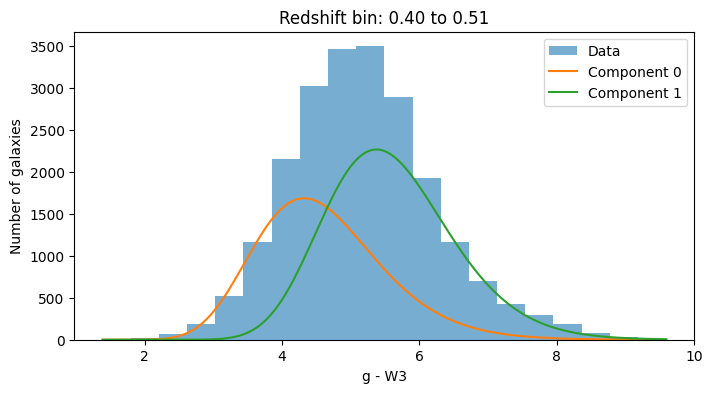

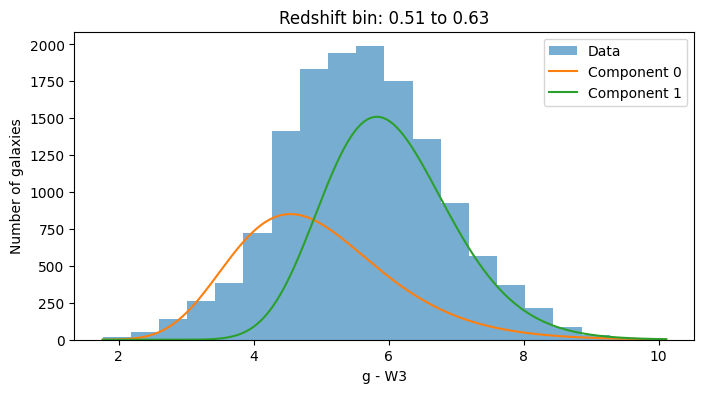

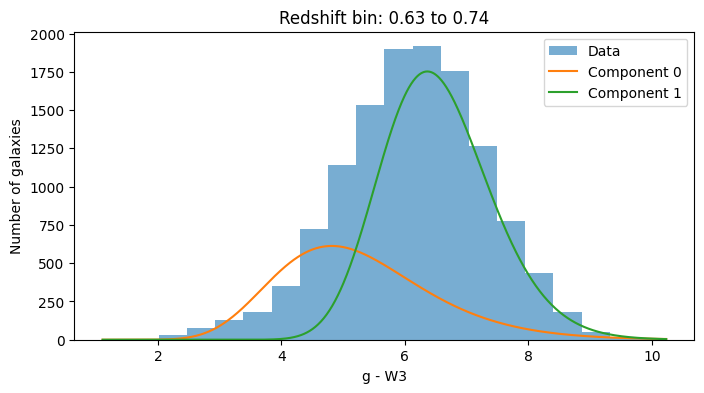

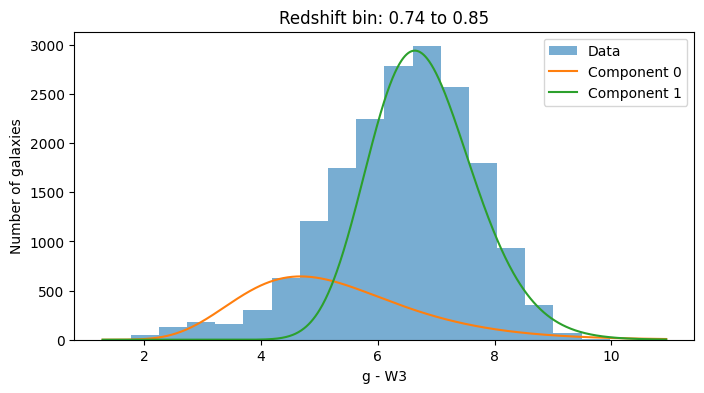

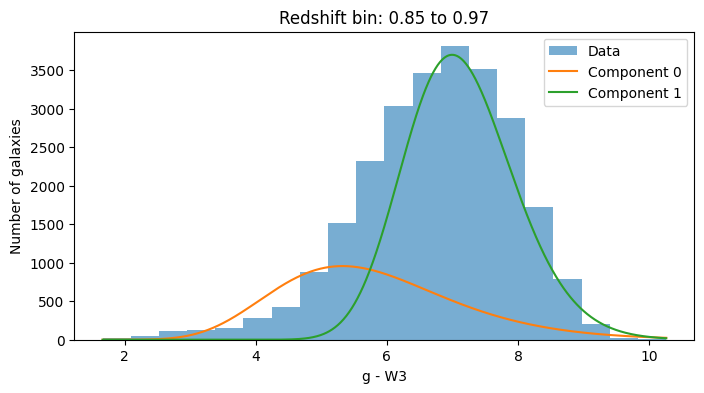

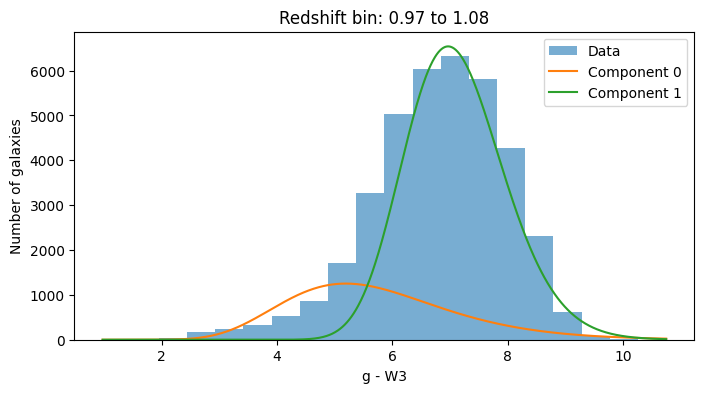

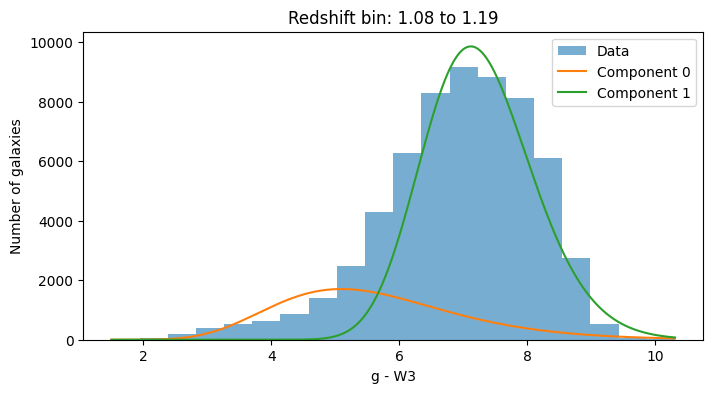

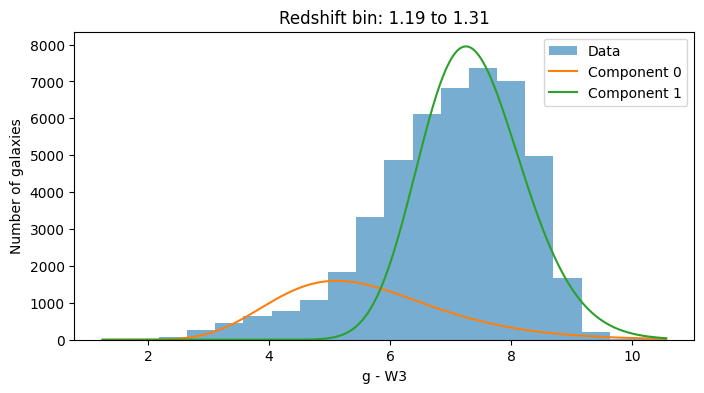

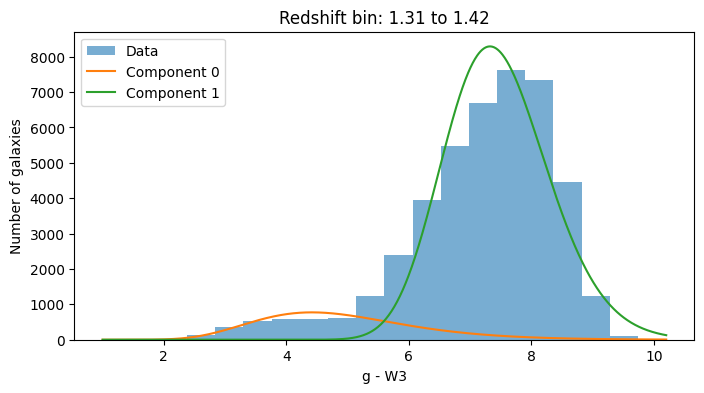

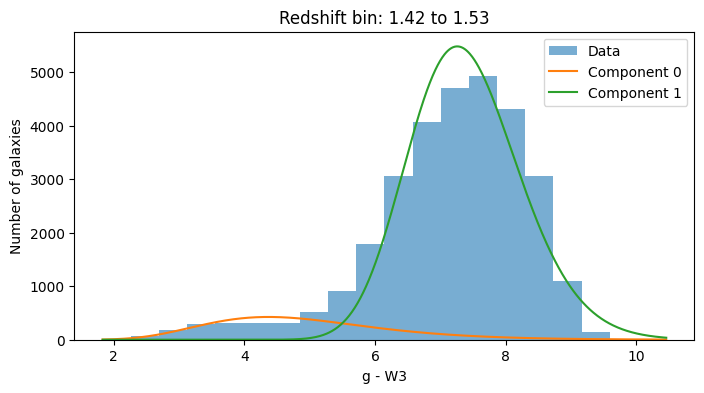

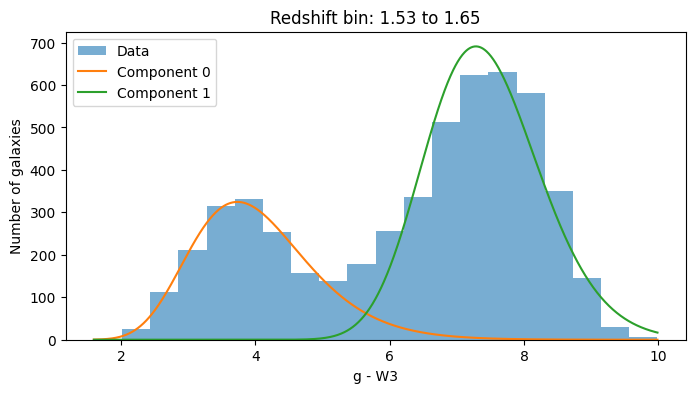

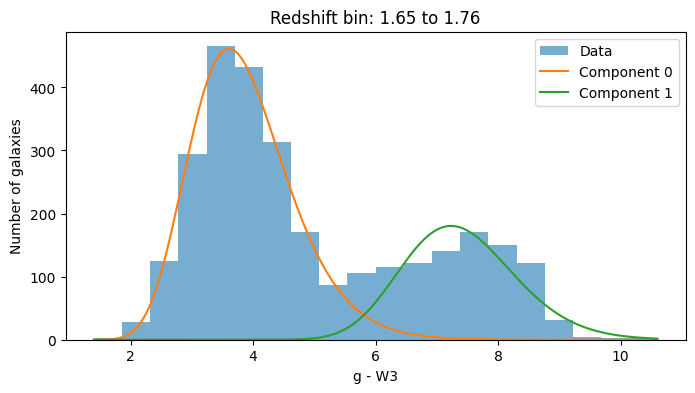

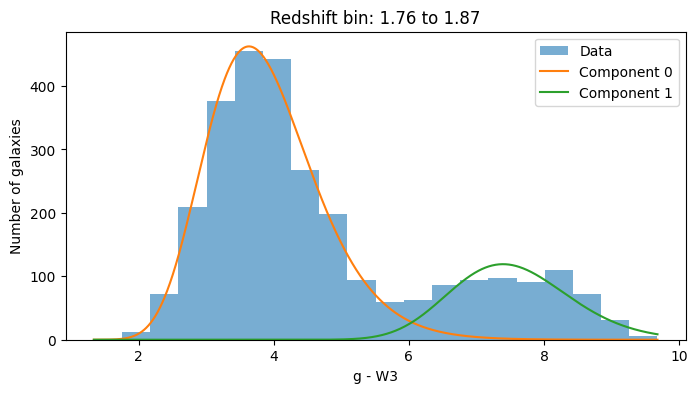

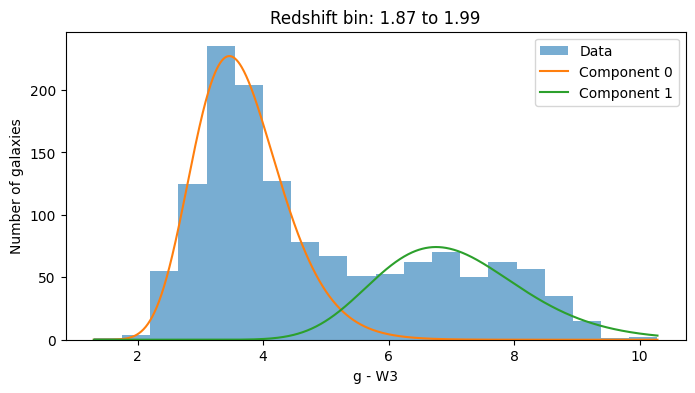

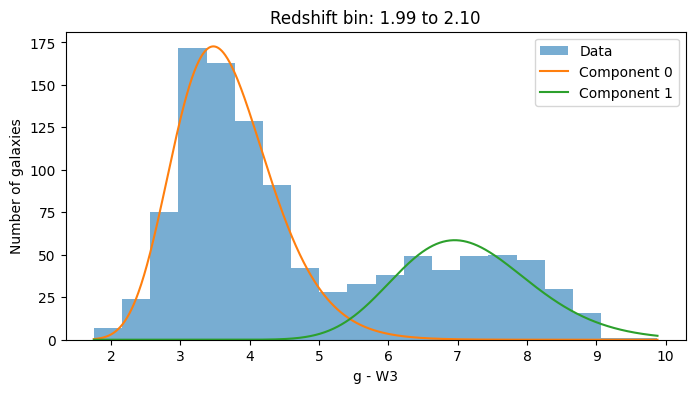

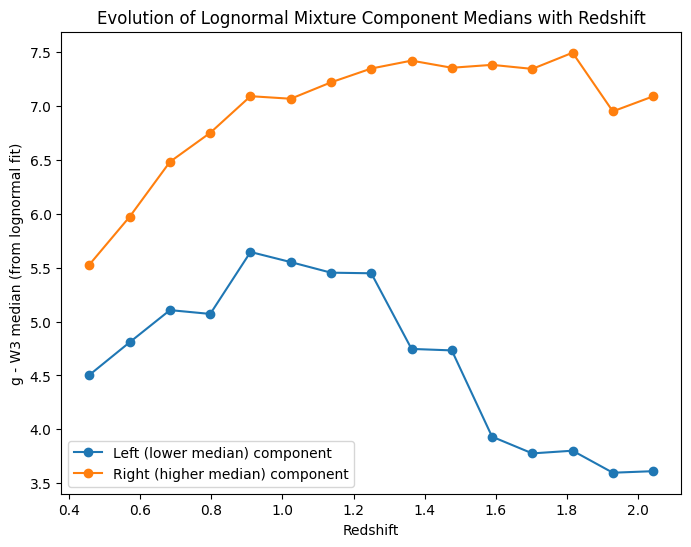

In [30]:
# --- Set Up Redshift Bins and Uncertainty Threshold ---
n_bins = 15
redshift_bins = np.linspace(0.4, 2.1, n_bins + 1)
#redshift_bins = np.linspace(df['redshift'].min(), df['redshift'].max(), n_bins + 1)
# Instead of using a difference in probabilities, we now require that the maximum probability be above a threshold.
max_prob_threshold = 0.8

# Containers for later analysis:
bin_centers = []
component_medians = []  # medians derived from the lognormal fits

df['p0'] = np.nan  # probability for component 0 (lower median)
df['p1'] = np.nan  # probability for component 1 (higher median)

# --- Process Each Redshift Bin ---
for i in range(n_bins):
    # Select data in the current redshift bin:
    mask = (df[colz] >= redshift_bins[i]) & (df[colz] < redshift_bins[i+1])
    sub_df = df[mask]
    if len(sub_df) < 20:  # Skip bins with too few objects
        continue
    
    # Get original g_W3 values (must be positive for the log transform)
    x_data = sub_df['gmw3'].values.reshape(-1, 1)
    # Transform to log space (for lognormal distributions)
    log_x = np.log(x_data)
    
    # Fit a 2-component GMM in log space:
    gmm = GaussianMixture(n_components=2, random_state=0)
    gmm.fit(log_x)
    
    # Get the posterior probabilities from the GMM:
    probs = gmm.predict_proba(log_x)
    # Get initial labels (which are arbitrary):
    original_labels = gmm.predict(log_x)
    
    # Reorder the components so that the one with the lower log-mean (i.e. lower median in original space) is label 0.
    # 'order' holds the indices that would sort the log-means in ascending order.
    order = np.argsort(gmm.means_.flatten())
    mapping = {order[0]: 0, order[1]: 1}
    fixed_labels = np.array([mapping[label] for label in original_labels])
    
    # IMPORTANT: Reorder the probability columns so that column 0 corresponds to the component with the lower log-mean.
    sorted_probs = probs[:, order]

    df.loc[sub_df.index, 'p0'] = sorted_probs[:, 0]
    df.loc[sub_df.index, 'p1'] = sorted_probs[:, 1]
    
    # Now use a maximum-probability criterion:
    # If the highest (reordered) probability is less than max_prob_threshold, mark the object as uncertain.
    max_probs = np.max(sorted_probs, axis=1)
    fixed_labels[max_probs < max_prob_threshold] = 2  # 2 indicates uncertain classification
    
    # Save the fixed labels into the DataFrame:
    df.loc[sub_df.index, 'agn_class'] = fixed_labels
    
    # Record the center of the current redshift bin:
    bin_center = (redshift_bins[i] + redshift_bins[i+1]) / 2.
    bin_centers.append(bin_center)
    # For a lognormal distribution, the median is exp(mu) where mu is the log-mean.
    medians = np.exp(np.sort(gmm.means_.flatten()))
    component_medians.append(medians)
    
    # --- Plot Histogram and Fitted Lognormal PDFs ---
    plt.figure(figsize=(8, 4))
    plt.hist(x_data, bins=20, alpha=0.6, label='Data')
    x_range = np.linspace(x_data.min(), x_data.max(), 1000)
    for j in range(2):
        # Identify the component index corresponding to the j-th sorted log-mean:
        sorted_means = np.sort(gmm.means_.flatten())
        comp_index = np.where(gmm.means_.flatten() == sorted_means[j])[0][0]
        mu = gmm.means_[comp_index][0]
        sigma = np.sqrt(gmm.covariances_[comp_index][0][0])
        weight = gmm.weights_[comp_index]
        # Lognormal PDF:
        # f(x) = weight * (1/(x * sigma * sqrt(2*pi))) * exp(-((ln(x)-mu)^2/(2*sigma^2)))
        pdf = weight * (1/(x_range * sigma * np.sqrt(2*np.pi))) * np.exp(-0.5*((np.log(x_range)-mu)/sigma)**2)
        bin_width = (x_data.max() - x_data.min())/20
        plt.plot(x_range, pdf * len(x_data)*bin_width, label=f'Component {j}')
    plt.title(f"Redshift bin: {redshift_bins[i]:.2f} to {redshift_bins[i+1]:.2f}")
    plt.xlabel("g - W3")
    plt.ylabel("Number of galaxies")
    plt.legend()
    plt.show()

# --- Plot Evolution of the Fitted Medians with Redshift ---
component_medians = np.array(component_medians)  # shape: (n_valid_bins, 2)
plt.figure(figsize=(8, 6))
plt.plot(bin_centers, component_medians[:, 0], 'o-', label="Left (lower median) component")
plt.plot(bin_centers, component_medians[:, 1], 'o-', label="Right (higher median) component")
plt.xlabel("Redshift")
plt.ylabel("g - W3 median (from lognormal fit)")
plt.title("Evolution of Lognormal Mixture Component Medians with Redshift")
plt.legend()
plt.show()


In [31]:
df.to_parquet('xxx.parquet')